<a href="https://colab.research.google.com/github/100mi/house-prediction/blob/master/House_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-requisite


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/house-prices-advanced-regression-techniques/test.csv')

In [0]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Analysis of `SalePrice`





In [0]:
train.shape

(1460, 81)

In [0]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness : 1.88
Kurtosis : 6.54


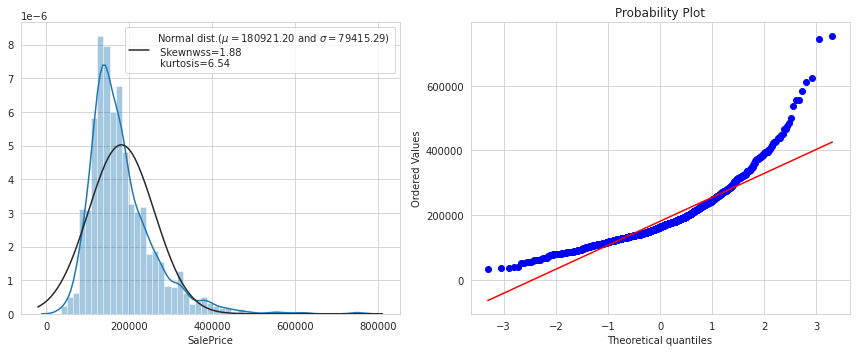

In [0]:
fig=plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(train['SalePrice'],fit=norm)
skewness = train['SalePrice'].skew()
kurtosis = train['SalePrice'].kurt()
(mu,sigma) = norm.fit(train['SalePrice'])
plt.legend(["Normal dist.($\mu=${:.2f} and $\sigma=${:.2f}) \n Skewnwss={:.2f} \n kurtosis={:.2f} ".format(mu,sigma,skewness,kurtosis)],loc='best')
plt.subplot(122)
SPprobplot=stats.probplot(train['SalePrice'],plot=plt)
plt.tight_layout()
print('Skewness : {:.2f}'.format(skewness))
print('Kurtosis : {:.2f}'.format(kurtosis))





*   SalePrice follows Positively Skewness pattern. 
*   It deviates from a normal distribution and has appreciable peakedness.
*   Probplot deviates from diagonal.








### Talking about Variables-


1.   Identifying all variables in the training set.
2.   Studying variables which have high impact over `SalePrice`.



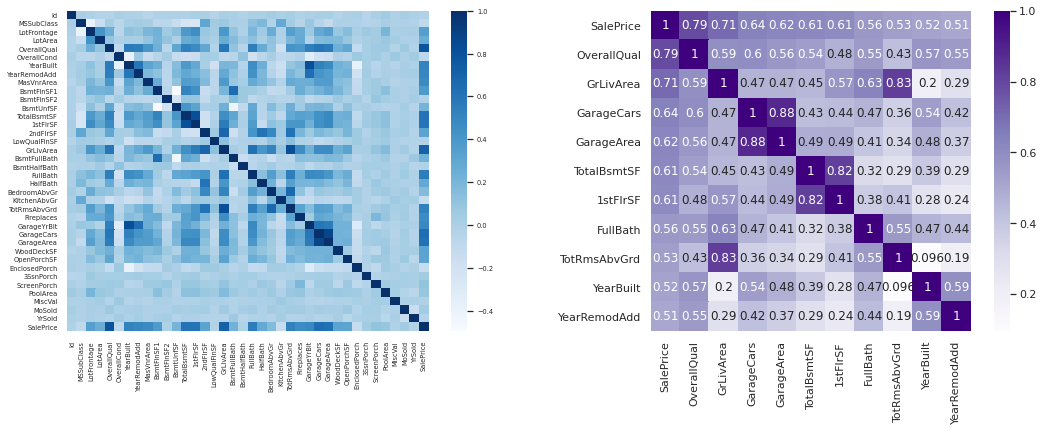

In [0]:
corrdata = train.corr()
sns.set(font_scale=0.6)
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.heatmap(corrdata,cmap='Blues')
#we observe that there are many pair of the variable that correlates to each other,
# hence in future we tend to eliminate few to make our model simple

#we need a zoomed heatmap that shows only high correlatd factors.
corrdata.sort_values(['SalePrice'],ascending=False,inplace=True)
zoomcorr=corrdata[corrdata.SalePrice>0.5]
sns.set(font_scale=1)
plt.subplot(122)
sns.heatmap(zoomcorr[zoomcorr.index],cmap='Purples',annot=True,square=True)
plt.tight_layout()

Variables that are highly correlated :
*   GrLivArea-TotRmsAbvGrd
*   GarageCars-GarageArea
*   TotalBsmtSF-1stFlrSF



1.   Ordinal(Categorical)- OverallQual
2.   Continuous(Numerical)-GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF
3.   Discrete(Numerical)-GarageCars,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd





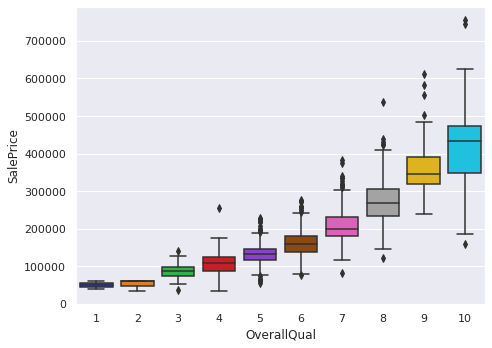

In [0]:
#taling about impactfull variables.
plt.figure(figsize=(7,5))
sns.boxplot(x="OverallQual",y="SalePrice",data=train,palette='bright')
plt.tight_layout()
#outlier is seen in qual=4

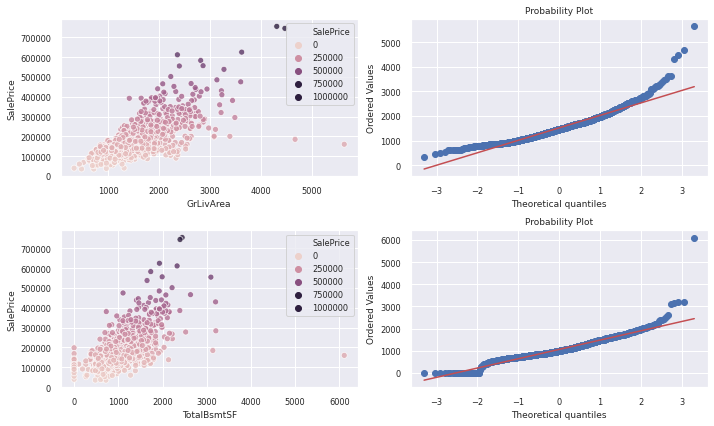

In [0]:
plt.figure(figsize=(10,6))
sns.set(font_scale=0.75)
plt.subplot(221)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train,alpha=0.8,hue='SalePrice')
plt.subplot(222)
problivarea=stats.probplot(train['GrLivArea'],plot=plt)
plt.subplot(223)
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train,alpha=0.8,hue='SalePrice')
plt.subplot(224)
probbsmt=stats.probplot(train['TotalBsmtSF'],plot=plt)
plt.tight_layout()
#1st floor surface area show high correlation with GrLivArea, Hence not considered.

In [0]:
#dropping outliers:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index,inplace=True)

#Resetting index:
train.reset_index(inplace=True,drop=True)
train.shape

(1457, 81)

In [0]:
#Separating train feature and SalePrice:
trainSP=train['SalePrice'].reset_index(drop=True)
trainfeat=train.drop('SalePrice',axis=1)

#combining test and trainfeat to fill vacant values:
allfeat=pd.concat([trainfeat,test],axis=0).reset_index(drop=True)
allfeat.shape

(2916, 80)

In [0]:
#numerical feature which should be an object.
train['MSSubClass'] = train['MSSubClass'].apply(str)

#making numerical feature and cat feature
def getfeat(dataset):
  numfeat=[]
  catfeat=[]
  numtype = ['int64','float64']
  for i in dataset.columns:
    if train[i].dtype in numtype:
      numfeat.append(i)
    else:
      catfeat.append(i)
  return numfeat,catfeat

#using above function to classify feature
numfeat , catfeat = getfeat(allfeat)

In [0]:
#calculating null values:
def getnulldataframe(dataset):
  nullfeat=dataset.isnull().sum()
  percent=(dataset.isnull().sum()/dataset.isnull().count())*100
  nulldf=pd.concat([nullfeat,percent],keys=['Tot_null_featues','Null_percent'],axis=1).sort_values('Null_percent',ascending=False)
  return nulldf
nullfeatdf = getnulldataframe(allfeat)
nullfeatdf.head()

,Tot_null_featues,Null_percent
PoolQC,2907,99.691358
MiscFeature,2811,96.399177
Alley,2718,93.209877
Fence,2345,80.418381
FireplaceQu,1420,48.696845


In [0]:
def fill_values(dataset):

  #concerning about garage:
  #Garage Numeric variables:
  for cols in ('GarageYrBlt','GarageCars','GarageArea'):
    dataset[cols].fillna(0,inplace=True)
  #Garage Categorical 
  for cols in ('GarageQual','GarageCond','GarageType','GarageFinish',):
    dataset[cols].fillna("NONE",inplace=True)
  
  #working with basement:
  #Numeric feature of Basement:
  for cols in ('BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'):
    dataset[cols].fillna(0,inplace=True)
  #Categoric Feauture of Basement:
  for cols in ('BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1'):
    dataset[cols].fillna("NONE",inplace=True)

  #working with MasVnr:
  dataset['MasVnrType'].fillna("NONE",inplace=True)
  dataset['MasVnrArea'].fillna(0,inplace=True)

  #working with Bath:
  dataset['BsmtFullBath'].fillna(0,inplace=True)
  dataset['BsmtHalfBath'].fillna(0,inplace=True)

  #working with fireplace:
  dataset['FireplaceQu'].fillna("NONE",inplace=True)

  #working with utilities:(most common feature)
  dataset['Utilities'].fillna('AllPub',inplace=True)

  #working with Functional:(most common feature)
  dataset['Functional'].fillna('Typ',inplace=True)

  #working with Exterior:
  dataset['Exterior1st'].fillna(dataset['Exterior1st'].mode()[0],inplace=True)
  dataset['Exterior2nd'].fillna(dataset['Exterior2nd'].mode()[0],inplace=True)

  #working with Exterior:
  dataset['Electrical'].fillna("SBrkr",inplace=True)

  #working with kitchen:overallqual-->overallcond-->kitchenqual
  dataset['KitchenQual'].fillna("TA",inplace=True)

  #working with poolqual:
  dataset['PoolQC'].fillna("NONE",inplace=True)

  #working with MiscFeature:
  dataset['MiscFeature'].fillna("NONE",inplace=True)

  #working with Alley:
  dataset['Alley'].fillna("NONE",inplace=True)

  #working with Fence:
  dataset['Fence'].fillna("NONE",inplace=True)

  #working with lot frontage:
  dataset['LotFrontage'] = dataset.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

  #working with MSZoning:
  dataset['MSZoning'] = dataset.groupby("MSSubClass")['MSZoning'].apply(lambda x : x.fillna(x.mode()[0]))

  #working with SaleType:
  dataset['SaleType'] = dataset['SaleType'].fillna(dataset['SaleType'].mode()[0])
  
  return dataset

fill_values(allfeat)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NONE,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NONE,NONE,NONE,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NONE,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NONE,NONE,NONE,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NONE,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NONE,NONE,NONE,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NONE,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NONE,NONE,NONE,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NONE,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NONE,NONE,NONE,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,2915,160,RM,21.0,1936,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NONE,NONE,0.0,NONE,0.0,0.0,NONE,NONE,Y,0,0,0,0,0,0,NONE,NONE,NONE,0,6,2006,WD,Normal
2912,2916,160,RM,21.0,1894,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NONE,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NONE,NONE,NONE,0,4,2006,WD,Abnorml
2913,2917,20,RL,160.0,20000,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NONE,NONE,NONE,0,9,2006,WD,Abnorml
2914,2918,85,RL,62.0,10441,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,

In [0]:
#checking that we fill allour missing data:
nullfeatdf = getnulldataframe(allfeat)
nullfeatdf.head()

,Tot_null_featues,Null_percent
Id,0,0.0
MSSubClass,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0


In [0]:
#Applying log(1+x) transformation on SalePrice to remove skewness:
trainSP = np.log1p(trainSP)

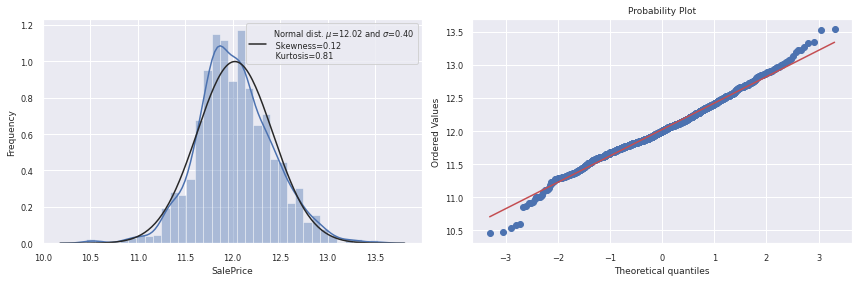

In [0]:
#Visualizing the effect og log(1+x) tranformatio
logSPskew=trainSP.skew()
logSPkurt=trainSP.kurt()
(logSPmu,logSPsigma) = norm.fit(trainSP)
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(trainSP,fit=norm)
plt.legend(['Normal dist. $\mu$={:.2f} and $\sigma$={:.2f} \n Skewness={:.2f} \n Kurtosis={:.2f}'.format(logSPmu,logSPsigma,logSPskew,logSPkurt)])
plt.ylabel('Frequency')
plt.subplot(122)
stats.probplot(trainSP,plot=plt)
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


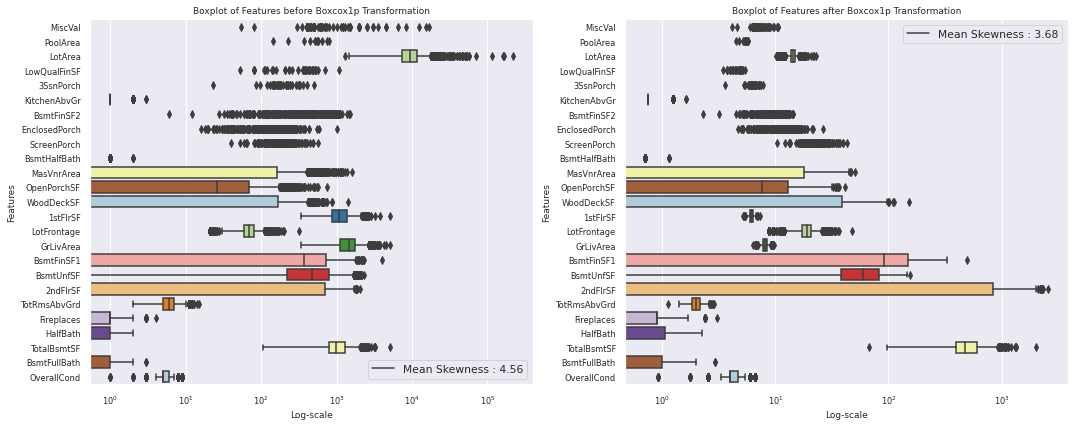

In [0]:
#getting skewness of numeric features:
def high_skew_feat(dataset):
  skewfeat=dataset[numfeat].apply(lambda x : x.skew()).sort_values(ascending=False)
  highskewfeat=skewfeat[skewfeat>0.5]
  return highskewfeat

featbeforebc = high_skew_feat(allfeat)

#representing boxplot before transformation:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.boxplot(data=allfeat[featbeforebc.index],orient="h",palette="Paired")
plt.title("Boxplot of Features before Boxcox1p Transformation")
plt.xscale("log")
plt.ylabel("Features")
plt.xlabel("Log-scale")
plt.legend(["Mean Skewness : {:.2f}".format(np.mean(featbeforebc))],fontsize="large")

#applying boxcox transformationL:
for feature in featbeforebc.index:
  allfeat[feature] = boxcox1p(allfeat[feature],boxcox_normmax(allfeat[feature]+1))

#visualising transformed features
featafterbc = high_skew_feat(allfeat)
plt.subplot(122)
sns.boxplot(data=allfeat[featbeforebc.index],orient="h",palette="Paired")
plt.title("Boxplot of Features after Boxcox1p Transformation")
plt.xscale("log")
plt.ylabel("Features")
plt.xlabel("Log-scale")
plt.legend(["Mean Skewness : {:.2f}".format(np.mean(featafterbc))],fontsize="large")
plt.tight_layout()

In [0]:
allfeat.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,18.133318,14.054263,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.990332,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438231,Gd,TA,PConc,Gd,TA,No,GLQ,143.920047,Unf,0.0,30.010267,422.114947,GasA,Ex,Y,SBrkr,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,Gd,2.262646,Typ,0.000000,NONE,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.000000,12.071122,0.0,0.0,0.0,0.0,NONE,NONE,NONE,0.0,2,2008,WD,Normal
1,2,20,RL,20.660028,14.347269,Pave,NONE,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,5.997763,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,181.454701,Unf,0.0,44.168168,593.327333,GasA,Ex,Y,SBrkr,6.224032,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,TA,1.997107,Typ,0.903299,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,56.101584,0.000000,0.0,0.0,0.0,0.0,NONE,NONE,NONE,0.0,5,2007,WD,Normal
2,3,60,RL,18.656316,14.716277,Pave,NONE,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.990332,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773262,Gd,TA,PConc,Gd,TA,Mn,GLQ,110.299851,Unf,0.0,56.942688,449.676734,GasA,Ex,Y,SBrkr,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,Gd,1.997107,Typ,0.903299,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.000000,9.894344,0.0,0.0,0.0,0.0,NONE,NONE,NONE,0.0,9,2008,WD,Normal


In [0]:
#getting ordinal categories that should be numerically encoded as rating 
str_ord_feat=[]
quality_values=['TA','Gd','Fa','Po','Ex','NONE']
for feature in catfeat:
   if set(allfeat[feature].unique()) <= set(quality_values):#REMEMBER THIS LIL TRICK
     str_ord_feat.append(feature)

#mapping numerical values to str_ord_feat to scale similiar to OverallQual:
ordinal_mapping = {'Ex':10,'Gd':8,'TA':6,'Fa':4,'Po':2,'NONE':0}
for feature in str_ord_feat:
  allfeat[feature]=allfeat[feature].map(ordinal_mapping)#REMEMBER THIS LIL TRICK
allfeat[str_ord_feat]

#merging quality and cond:
def get_rating(qual,cond):
  rating = ((allfeat[qual]*10)+(allfeat[cond]))/11 
  return rating

#Creating new feature as _rating for quality and conditions. 
allfeat["Overall_rating"]=get_rating('OverallQual','OverallCond')
allfeat["Exter_rating"]=get_rating('ExterQual','ExterCond')
allfeat["Bsmt_rating"]=get_rating('BsmtQual','BsmtCond')
allfeat["Garage_rating"]=get_rating('GarageQual','GarageCond')

In [0]:
#mapping BasementFin :
bsmt_map = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0,'NONE':0}
for feat in ['BsmtFinType1','BsmtFinType2']:
  allfeat[feat] = allfeat[feat].map(bsmt_map)

#mapping electrical:
elec_map = {'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1}
allfeat['Electrical']=allfeat['Electrical'].map(elec_map)

In [0]:
null_allfeat = allfeat.isnull().sum()
naf=null_allfeat[null_allfeat>0]
naf

Series([], dtype: int64)

In [0]:
#how many years house is there
allfeat["YearSinceRemod"] = allfeat["YrSold"] - allfeat["YearRemodAdd"] #remember to drop

#area living
allfeat['Total_sqr_footage'] = (allfeat['BsmtFinSF1'] + allfeat['BsmtFinSF2'] +allfeat['1stFlrSF'] + allfeat['2ndFlrSF'])#remember to drop

#total bathrooms:
allfeat["TotBath"] = (allfeat['HalfBath'] + allfeat['BsmtHalfBath'])*0.5 + allfeat['BsmtFullBath'] + allfeat['FullBath']

#def for porches
allfeat["Tot_Porch_SF"] = allfeat["WoodDeckSF"]+allfeat["OpenPorchSF"]+allfeat["EnclosedPorch"]+allfeat["3SsnPorch"]+allfeat["ScreenPorch"]

In [0]:
drop_feat=['MoSold','GarageQual','GarageCond','BsmtQual','BsmtCond','ExterQual','ExterCond','OverallQual','OverallCond','Id','YearRemodAdd']
for feature in allfeat.columns:
  if ("Bath" in feature) and ("Tot" not in feature):
    drop_feat.append(feature)
drop_feat
allfeat.drop(drop_feat,axis=1,inplace=True)

In [0]:
allfeat.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,Overall_rating,Exter_rating,Bsmt_rating,Garage_rating,YearSinceRemod,Total_sqr_footage,TotBath,Tot_Porch_SF
0,60,RL,18.133318,14.054263,Pave,NONE,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,19.438231,PConc,No,6,143.920047,1,0.0,30.010267,422.114947,GasA,10,Y,5,5.929136,1026.391549,0.0,8.339939,3,0.750955,8,2.262646,Typ,0.000000,0,Attchd,2003.0,RFn,2.0,548.0,Y,0.000000,12.071122,0.0,0.0,0.0,0.0,0,NONE,NONE,0.0,2008,WD,Normal,6.726394,7.818182,7.818182,6.0,5,1176.240731,3.527724,12.071122
1,20,RL,20.660028,14.347269,Pave,NONE,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,CBlock,Gd,5,181.454701,1,0.0,44.168168,593.327333,GasA,10,Y,5,6.224032,0.000000,0.0,7.962253,3,0.750955,6,1.997107,Typ,0.903299,6,Attchd,1976.0,RFn,2.0,460.0,Y,56.101584,0.000000,0.0,0.0,0.0,0.0,0,NONE,NONE,0.0,2007,WD,Normal,5.999797,6.000000,7.818182,6.0,31,187.678733,2.355469,56.101584
2,60,RL,18.656316,14.716277,Pave,NONE,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,17.773262,PConc,Mn,6,110.299851,1,0.0,56.942688,449.676734,GasA,10,Y,5,5.984244,1041.273148,0.0,8.394288,3,0.750955,8,1.997107,Typ,0.903299,6,Attchd,2001.0,RFn,2.0,608.0,Y,0.000000,9.894344,0.0,0.0,0.0,0.0,0,NONE,NONE,0.0,2008,WD,Normal,6.726394,7.818182,7.818182,6.0,6,1157.557243,3.527724,9.894344


In [0]:
allfeat = pd.get_dummies(allfeat,drop_first=True)
allfeat.head()

,MSSubClass,LotFrontage,LotArea,YearBuilt,MasVnrArea,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,Overall_rating,Exter_rating,Bsmt_rating,Garage_rating,YearSinceRemod,...,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NONE,GarageFinish_Fin,GarageFinish_NONE,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NONE,MiscFeature_Gar2,MiscFeature_NONE,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,18.133318,14.054263,2003,19.438231,6,143.920047,1,0.0,30.010267,422.114947,10,5,5.929136,1026.391549,0.0,8.339939,3,0.750955,8,2.262646,0.000000,0,2003.0,2.0,548.0,0.000000,12.071122,0.000000,0.0,0.0,0.0,0,0.0,2008,6.726394,7.818182,7.818182,6.0,5,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,20.660028,14.347269,1976,0.000000,5,181.454701,1,0.0,44.168168,593.327333,10,5,6.224032,0.000000,0.0,7.962253,3,0.750955,6,1.997107,0.903299,6,1976.0,2.0,460.0,56.101584,0.000000,0.000000,0.0,0.0,0.0,0,0.0,2007,5.999797,6.000000,7.818182,6.0,31,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,18.656316,14.716277,2001,17.773262,6,110.299851,1,0.0,56.942688,449.676734,10,5,5.984244,1041.273148,0.0,8.394288,3,0.750955,8,1.997107,0.903299,6,2001.0,2.0,608.0,0.000000,9.894344,0.000000,0.0,0.0,0.0,0,0.0,2008,6.726394,7.818182,7.818182,6.0,6,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,17.239197,14.335210,1915,0.000000,5,61.728759,1,0.0,64.863764,378.526862,8,5,6.017495,905.115976,0.0,8.345041,3,0.750955,8,2.137976,0.903299,8,1998.0,3.0,642.0,0.000000,8.960357,16.025062,0.0,0.0,0.0,0,0.0,2006,6.726394,6.000000,6.181818,6.0,36,...,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,21.300075,15.277957,2000,25.411668,6,136.439665,1,0.0,61.217218,544.803190,10,5,6.150533,1273.975831,0.0,8.654709,4,0.750955,8,2.374499,0.903299,6,2000.0,3.0,836.0,42.189389,14.259706,0.000000,0.0,0.0,0.0,0,0.0,2008,7.635485,7.818182,7.818182,6.0,8,...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
flfeat=[]
for feature in allfeat.columns:
  if allfeat[feature].dtype == 'float64':
    flfeat.append(feature)

for feature in flfeat:
  allfeat[feature]=allfeat[feature].apply(lambda x :"{:.3f}".format(x) )

In [0]:
traindata = allfeat[:len(trainSP)]
traindata.shape

(1457, 240)

In [0]:
testdata = allfeat[len(trainSP):]
testdata.shape

(1459, 240)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(traindata,trainSP,test_size=0.3,random_state=100)

In [0]:
#defining cross validation score:
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.model_selection import KFold , cross_val_score ,GridSearchCV
from  sklearn.linear_model import Ridge , Lasso ,RidgeCV , LassoCV

In [0]:
#Linear Model without Regularization:
lr = LinearRegression()
lr.fit(X_train,y_train)
Xtrain_pred = lr.predict(X_train)
Xtest_pred = lr.predict(X_test)

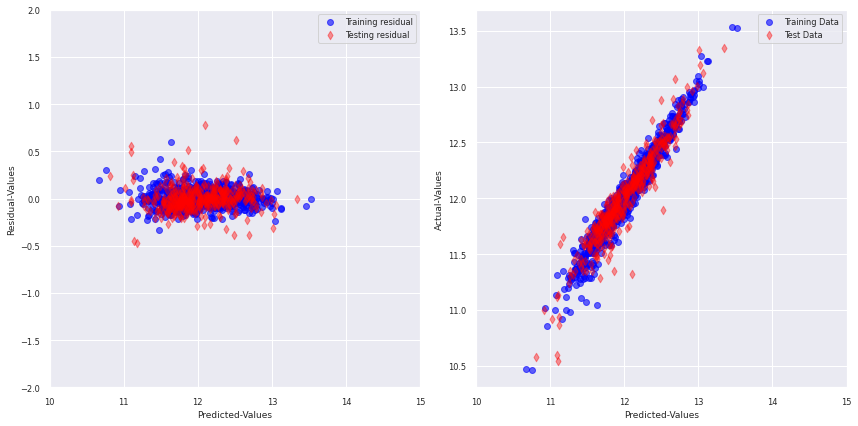

In [0]:
#visualising our fit.
plt.figure(figsize=(12,6))
sns.set_style()
plt.subplot(121)
plt.scatter(x=Xtrain_pred,y=Xtrain_pred-y_train,c='blue',label='Training residual',alpha=0.6)
plt.scatter(x=Xtest_pred,y=Xtest_pred - y_test , c='red',label='Testing residual',alpha=0.4,marker='d')
plt.xlabel('Predicted-Values')
plt.ylabel('Residual-Values')
plt.xlim(10,15)
plt.ylim(-2,2)
plt.legend()
plt.subplot(122)
plt.scatter(x=Xtrain_pred , y=y_train,c='blue',label='Training Data',alpha=0.6)
plt.scatter(x=Xtest_pred,y=y_test,c='red',label='Test Data',alpha=0.4,marker='d')
plt.xlabel('Predicted-Values')
plt.ylabel('Actual-Values')
plt.xlim(10,15)
plt.legend()
plt.tight_layout()

In [0]:
#creating with Ridge:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(traindata,trainSP)
alpha = ridge.alpha_
print('best alpha',alpha)

ridge = Ridge(alpha=6,normalize=True)
ridge.fit(traindata,trainSP)
print("Score on Train data is :{} ".format(ridge.score(traindata,trainSP)))

best alpha 6.0
Score on Train data is :0.8110166444400417 


In [0]:
test_pred = ridge.predict(testdata)
test_pred.shape

(1459,)

In [0]:
test_pred 

array([11.79125294, 11.99221038, 12.13133544, ..., 12.02985685,
       11.73075235, 12.24360394])

In [0]:
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(test_pred))

In [0]:
submission.head()

,Id,SalePrice
0,1461,132090.869633
1,1462,161490.917756
2,1463,185596.464765
3,1464,201500.827966
4,1465,182307.729872


In [0]:
submission.to_csv("submission.csv", index=False)